# Install Transformers Library

In [ ]:
!pip install wandb boto3 torchmetrics gdown==4.6.0

In [53]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.preprocessing import LabelEncoder
import wandb
from io import BytesIO, StringIO
import boto3
import itertools
import re
from pathlib import Path
from typing import List
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAUROC
device = torch.device("cuda")
#torch.cuda.empty_cache()

In [9]:
BUCKET_NAME = "mlds23-authorship-identification"
BUCKET_DIR = "splitted_data/"
FILENAME = 'splitted_df.csv'
seed = 42
model_name = 'DeepPavlov/rubert-base-cased'+str(seed)

In [10]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
wandb.init(project="authorship_identification", name=model_name, entity="mlds23_ai", tags=['bert'])

wandb: Currently logged in as: dariamishina2812 (mlds23_ai). Use `wandb login --relogin` to force relogin


In [12]:
wandb.config['random_state'] = seed
wandb.config['dataset'] = FILENAME

# Load Dataset

In [98]:
session = boto3.session.Session()

In [99]:
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id='REDACTED_KEY_ID_1',
    aws_secret_access_key='REDACTED_SECRET_KEY_1',
    region_name='ru-cental1'
)

In [100]:
csv_obj = s3.get_object(Bucket=BUCKET_NAME, Key=BUCKET_DIR + FILENAME)

In [101]:
df = pd.read_csv(StringIO(csv_obj['Body'].read().decode('utf-8')))
print(df.shape)

(11715, 3)


In [18]:
enc = LabelEncoder()
df['author_id'] = enc.fit_transform(df['target'])

In [19]:
df.rename(columns={'author_id': 'label', 'text': 'text'}, inplace=True)

In [20]:
df = df[['label', 'text']]
df.head()

,label,text
0,6,"Узкими горными тропинками , от одного дачного ..."
1,6,свернутый ковер для акробатических упражнений ...
2,6,"позабытые . Кроме того , были в шарманке две п..."
3,6,тайной грусти : — Что поделаешь ? .. Древний о...
4,6,", да уж ладно ! Кормила она нас с тобой , Серг..."


In [21]:
# check class distribution
df['label'].value_counts(normalize = True)

2    0.230986
9    0.203756
0    0.110883
4    0.110542
6    0.089373
3    0.068630
5    0.061886
8    0.053521
7    0.038071
1    0.032352
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [22]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=seed,
                                                                    test_size=0.2,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=seed,
                                                                test_size=0.2,
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [28]:
# import BERT-base pretrained model
model_name = 'bert-base-uncased'
model_name = 'cointegrated/rubert-tiny2'
model_name = 'DeepPavlov/rubert-base-cased'

wandb.config['classifier'] = model_name

bert = AutoModel.from_pretrained(model_name)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
df.text[0]

'Узкими горными тропинками , от одного дачного поселка до другого , пробиралась вдоль южного берега Крыма маленькая бродячая труппа . Впереди обыкновенно бежал , свесив набок длинный розовый язык , белый пудель Арто , остриженный наподобие льва . У перекрестков он останавливался и , махая хвостом , вопросительно оглядывался назад . По каким-то ему одному известным признакам он всегда безошибочно узнавал дорогу и , весело болтая мохнатыми ушами , кидался галопом вперед . За собакой шел двенадцатилетний мальчик Сергей ,'

In [31]:
# sample data
text = [df.text[0]]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [32]:
# output
print(sent_id)

{'input_ids': [[101, 14220, 13224, 72328, 19318, 49787, 128, 1641, 8237, 26269, 1766, 28581, 2785, 17743, 128, 107594, 5172, 16066, 33190, 19783, 17196, 45355, 67310, 1637, 61931, 132, 109020, 60893, 25182, 128, 2060, 24267, 846, 7084, 1770, 34932, 68034, 11910, 128, 23497, 56380, 1644, 12752, 613, 128, 92786, 24367, 1916, 45120, 50250, 132, 815, 45256, 2570, 2886, 74721, 851, 128, 25221, 1637, 61426, 128, 7079, 5606, 94320, 16723, 12345, 132, 3099, 22528, 130, 3815, 6164, 17660, 19534, 47586, 2886, 12929, 110804, 8908, 27088, 1444, 23960, 851, 128, 88878, 100872, 1637, 59176, 21404, 5310, 116889, 128, 49441, 3431, 98602, 45143, 23187, 132, 6351, 70881, 29517, 38972, 29648, 28677, 10932, 128, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

# Tokenization

<Axes: >

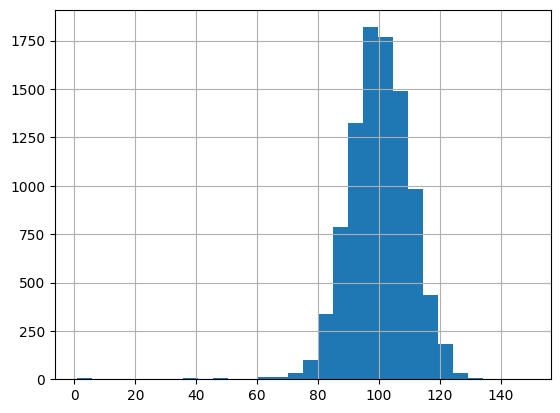

In [33]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [34]:
max_seq_len = 140

In [35]:

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [36]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


# Create DataLoaders

In [37]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16 #не для tiny - 16, иначе не влезает в память

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [38]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Токенайзер

In [49]:
!gdown 1cfarxzBfJubx0wwla2f1mCo9ZmN1XdG0 #файл лежит на гугл диске, там стопслова

Downloading...
From: https://drive.google.com/uc?id=1cfarxzBfJubx0wwla2f1mCo9ZmN1XdG0
To: /content/russian.txt
100% 115k/115k [00:00<00:00, 86.1MB/s]


In [52]:
RUSSIAN_VOCABULARY_PATH = Path("/content/russian.txt")

RUSSIAN_LETTERS = [
    "а",
    "б",
    "в",
    "г",
    "д",
    "е",
    "ё",
    "ж",
    "з",
    "и",
    "й",
    "к",
    "л",
    "о",
    "м",
    "н",
    "о",
    "п",
    "р",
    "с",
    "т",
    "у",
    "ф",
    "х",
    "ц",
    "ч",
    "ш",
    "щ",
    "ъ",
    "ы",
    "ь",
    "э",
    "ю",
    "я",
]


def get_corpus():
    corpus = set()
    with open(RUSSIAN_VOCABULARY_PATH, "r", encoding="utf-8") as f:
        for line in f.readlines():
            word = line.strip()
            if not re.search("[а-яА-Я]", word):
                continue
            corpus.add(word)
    return list(corpus)


def generate_ngrams(n, chars):
    res = []
    for item in itertools.product(chars, repeat=n):
        res.append("".join(item))
    return res


In [54]:
class SparseFeaturizer(nn.Module):
    def __init__(self, max_length):
        super().__init__()
        self._words_one_hot = OneHotEncoder(handle_unknown="ignore")
        self._words_one_hot.fit(np.array(get_corpus()).reshape(-1, 1))
        self._unigrams_encoder = CountVectorizer(analyzer="char")
        self._unigrams_encoder.fit(generate_ngrams(1, RUSSIAN_LETTERS))
        self._bigrams_encoder = CountVectorizer(analyzer="char", ngram_range=(2, 2))
        self._bigrams_encoder.fit(generate_ngrams(2, RUSSIAN_LETTERS))
        self._max_length = max_length

    def forward(self, x: List[str]):
        words_ohe = []
        unigrams = []
        bigrams = []

        for sentence in x:
            tokens = sentence.lower().strip().split(" ")[: self._max_length]
            words_ohe.append(np.array(self._words_one_hot.transform(np.array(tokens).reshape(-1, 1)).toarray()))
            unigrams.append(self._unigrams_encoder.transform(tokens).toarray())
            bigrams.append(self._bigrams_encoder.transform(tokens).toarray())

        words_ohe = self._pad(words_ohe)
        words_ohe = torch.tensor(words_ohe)

        unigrams = self._pad(unigrams)
        unigrams = torch.tensor(unigrams)

        bigrams = self._pad(bigrams)
        bigrams = torch.tensor(bigrams)

        return torch.cat([words_ohe, unigrams, bigrams], dim=-1).to(torch.float32)

    def _pad(self, arrays: np.ndarray):
        return np.array([np.pad(array, pad_width=((0, self._max_length - array.shape[0]), (0, 0))) for array in arrays])


# Define Model Architecture

In [55]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()
      #TODO добавить tokenizer_max_length как параметр, пока просто руками указала 140
      ##self._tokenizer_max_length = tokenizer_max_length
      ##self._sparse_featurizer = SparseFeaturizer(tokenizer_max_length)
      self._sparse_featurizer = SparseFeaturizer(140)

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      #self.fc1 = nn.Linear(312,128) #tiny

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,10) #TODO добавить кол-во классов как параметр (сейчас 10)
      #self.fc2 = nn.Linear(128,10) #tiny #10 кол-во классов

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False) #добавила return_dict=False

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [56]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [68]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
learning_rate = 1e-3
optimizer = AdamW(model.parameters(), lr = learning_rate)

# Find Class Weights увеличить эпохи если лосс на валидации будет уменьшаться

In [70]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight ='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.90202117 3.09306931 0.43288684 1.45754277 0.9046332  1.61586207
 1.11971326 2.62521008 1.86693227 0.49068063]


In [73]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) #TODO loss попробовать другой к-л

# number of training epochs
epochs = 10 # 20 чуууууть лучше

In [75]:
#TODO подумать что еще можно указать как параметры модели
wandb.config['classifier'] = {
        'classifier_name': model_name,
        'SparseFeaturizer': True,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "loss": cross_entropy
    }

# Fine-Tune BERT

In [76]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [78]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [82]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()
    wandb.log({"epoch": epoch, "train_loss": train_loss})

    #evaluate model
    valid_loss, _ = evaluate()
    wandb.log({"epoch": epoch, "valid_loss": valid_loss})

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    586.
  Batch   100  of    586.
  Batch   150  of    586.
  Batch   200  of    586.
  Batch   250  of    586.
  Batch   300  of    586.
  Batch   350  of    586.
  Batch   400  of    586.
  Batch   450  of    586.
  Batch   500  of    586.
  Batch   550  of    586.

Evaluating...
  Batch    50  of    118.
  Batch   100  of    118.

Training Loss: 1.476
Validation Loss: 1.385

 Epoch 2 / 10
  Batch    50  of    586.
  Batch   100  of    586.
  Batch   150  of    586.
  Batch   200  of    586.
  Batch   250  of    586.
  Batch   300  of    586.
  Batch   350  of    586.
  Batch   400  of    586.
  Batch   450  of    586.
  Batch   500  of    586.
  Batch   550  of    586.

Evaluating...
  Batch    50  of    118.
  Batch   100  of    118.

Training Loss: 1.470
Validation Loss: 1.425

 Epoch 3 / 10
  Batch    50  of    586.
  Batch   100  of    586.
  Batch   150  of    586.
  Batch   200  of    586.
  Batch   250  of    586.
  Batch   300  of    586.
  B

# Load Saved Model

In [83]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [106]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [107]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds, target_names=enc.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).tolist()))

              precision    recall  f1-score   support

author_id_00       0.56      0.69      0.62        52
author_id_01       0.65      0.87      0.74        15
author_id_02       0.88      0.13      0.23       108
author_id_03       0.30      0.41      0.34        32
author_id_04       0.48      0.60      0.53        52
author_id_05       0.33      0.59      0.42        29
author_id_06       0.41      0.64      0.50        42
author_id_07       0.36      0.67      0.47        18
author_id_08       0.35      0.52      0.42        25
author_id_09       0.53      0.40      0.45        96

    accuracy                           0.46       469
   macro avg       0.48      0.55      0.47       469
weighted avg       0.56      0.46      0.43       469



In [119]:
report = classification_report(test_y, preds, target_names=enc.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).tolist(), output_dict=True)
wandb.log({
    'precision_recall_f1_table_test': wandb.Table(dataframe=pd.DataFrame(report).transpose())})

In [121]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,36,1,0,1,4,1,3,3,1,2
1,0,13,0,1,0,0,1,0,0,0
2,10,1,14,10,10,14,12,8,6,23
3,2,1,0,13,1,3,4,4,3,1
4,6,0,0,1,31,5,1,2,2,4
5,1,1,0,1,1,17,5,0,1,2
6,3,1,0,1,0,2,27,4,4,0
7,0,0,0,3,0,2,1,12,0,0
8,0,1,0,2,4,1,2,0,13,2


In [120]:
wandb.log({
    'conf_mat_test': wandb.plot.confusion_matrix(probs=None, y_true=test_y.tolist(), preds=preds.tolist(), class_names=enc.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).tolist())
})

## roc_auc_score

In [122]:
logits = model(test_seq.to(device), test_mask.to(device))
probabilities = F.softmax(logits, dim=-1)
probabilities

tensor([[2.7648e-02, 5.1118e-05, 5.1385e-02,  ..., 8.4561e-03, 4.0074e-01,
         1.1704e-01],
        [1.8395e-02, 1.3042e-02, 9.1702e-02,  ..., 4.0548e-03, 3.9734e-02,
         4.4780e-01],
        [8.2324e-02, 1.4453e-04, 9.8369e-03,  ..., 1.4298e-03, 1.0522e-02,
         7.0316e-02],
        ...,
        [8.5570e-02, 3.2407e-04, 1.0365e-02,  ..., 6.6864e-03, 1.5924e-01,
         5.1223e-01],
        [7.8130e-03, 6.7410e-04, 3.2923e-02,  ..., 3.3793e-04, 1.8379e-02,
         7.0361e-01],
        [5.6503e-04, 1.9096e-05, 6.9812e-02,  ..., 8.5420e-04, 4.7500e-02,
         7.5469e-02]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [125]:
mc_auroc = MulticlassAUROC(num_classes=10, average="macro", thresholds=10).to(device)
mc_auroc(probabilities, test_y.to(torch.device('cuda')))

tensor(0.8546, device='cuda:0')

In [126]:
mc_auroc = MulticlassAUROC(num_classes=10, average=None, thresholds=10).to(device)
mc_auroc(probabilities, test_y.to(torch.device('cuda')))

tensor([0.9016, 0.9946, 0.6844, 0.7807, 0.8823, 0.8938, 0.8735, 0.9192, 0.7916,
        0.8245], device='cuda:0')